# Prepare data and libraries
You can copy (drag/drop) the zip to the colab top directory and then unzip it from there.  However, the copy takes a unusually log time.  It is much faster to first copy the zip file to Google Drive and the copy to colab.  We also import libraries and do sanity checks to make sure the python and libraries are compatible.

Mount the Google Drive to your colab directory.  Note that you will be prompted each session to allow this permission.

In [ ]:
!unzip -q health.zip

Now import libraries and check compatabilities.

In [19]:
import sys

assert sys.version_info >= (3, 7)

In [20]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

In [21]:
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")
print(tf.__version__)

2.16.1


(Optional) Define the default font sizes to make the figures prettier:

In [22]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Can be very slow without a GPU, check if there's one, or else issue a warning

In [23]:
# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


## Faster GPUs

<p>Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in <code>Runtime &gt; Change runtime type</code> in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.</p>
<p>The free-of-charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.</p>

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is 'Not connected to a GPU', you can change the runtime by going to <code>Runtime &gt; Change runtime type</code> in the menu to enable a GPU accelerator, and then re-execute the code cell.

In [24]:
# If you have purchased google colab 
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Not connected to a GPU


## More memory

Users who have purchased one of Colab's paid plans have access to high-memory VMs when they are available.
You can see how much memory you have available at any time by running the following code cell. If the execution result of running the code cell below is 'Not using a high-RAM runtime', then you can enable a high-RAM runtime via <code>Runtime &gt; Change runtime type</code> in the menu. Then select High-RAM in the Runtime shape drop-down. After, re-execute the code cell.

In [25]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
    print('Not using a high-RAM runtime')
else:
    print('You are using a high-RAM runtime!')

Your runtime has 32.8 gigabytes of available RAM

You are using a high-RAM runtime!


In [26]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
#import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import pandas as pd
print(tf.__version__)

2.16.1


### Change to directory with more space (/home/ubuntu/) is limited to 14G in standard DLAMI.  Remaining references should use relative paths.

In [27]:
# The following does not seem to work :(
#!cd /opt/dlami/nvme/
#!pwd
import os
os.chdir('/mnt/efs/fs1/ham')
!pwd

/mnt/efs/fs1/ham


# Read metadata file

In [28]:
metadata=pd.read_csv(os.path.join(".",'HAM10000_metadata.csv'))
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


In [29]:
#To analyse basics of Dataset we study first 5 rows of HAAM10000 Dataset
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [30]:
#Checking for NA
metadata.isna().isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

In [31]:
metadata.describe(include='all')

,lesion_id,image_id,dx,dx_type,age,sex,localization
count,10015,10015,10015,10015,9958.000000,10015,10015
unique,7470,10015,7,4,NaN,3,15
top,HAM_0003789,ISIC_0032258,nv,histo,NaN,male,back
freq,6,1,6705,5340,NaN,5406,2192
mean,NaN,NaN,NaN,NaN,51.863828,NaN,NaN
std,NaN,NaN,NaN,NaN,16.968614,NaN,NaN
min,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,40.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,50.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,65.000000,NaN,NaN


In [33]:
import seaborn as sns

/tmp/ipykernel_3115/712836335.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)


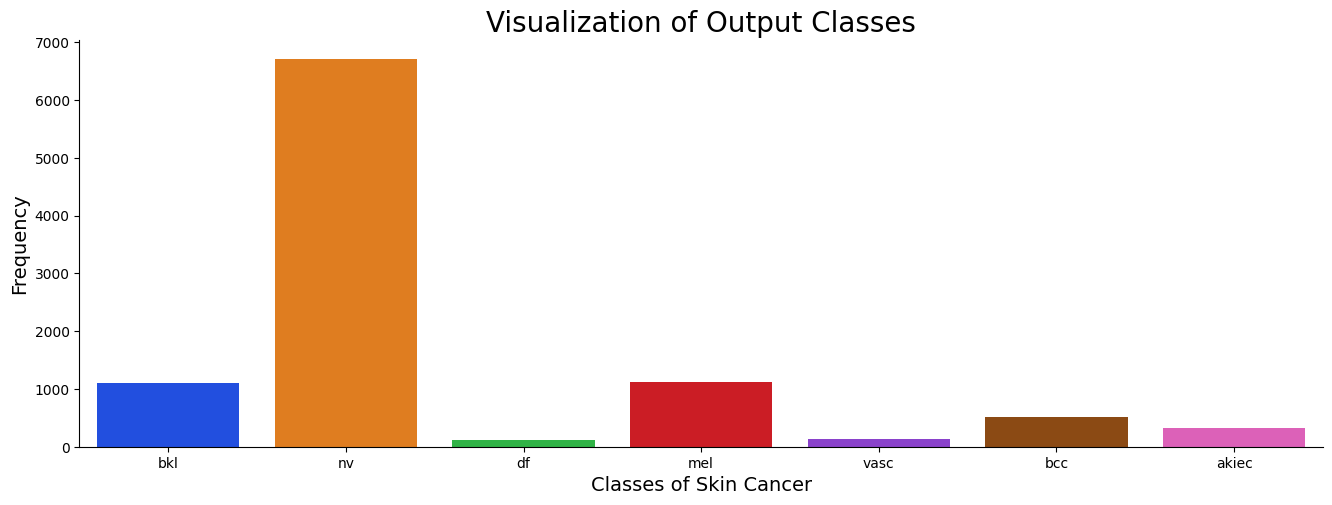

In [34]:
# We need to predict the cancer type, let's check the distribution of the values
g = sns.catplot(x="dx", kind="count", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Visualization of Output Classes', fontsize=20)
g.set_xlabels('Classes of Skin Cancer', fontsize=14)
g.set_ylabels('Frequency', fontsize=14)

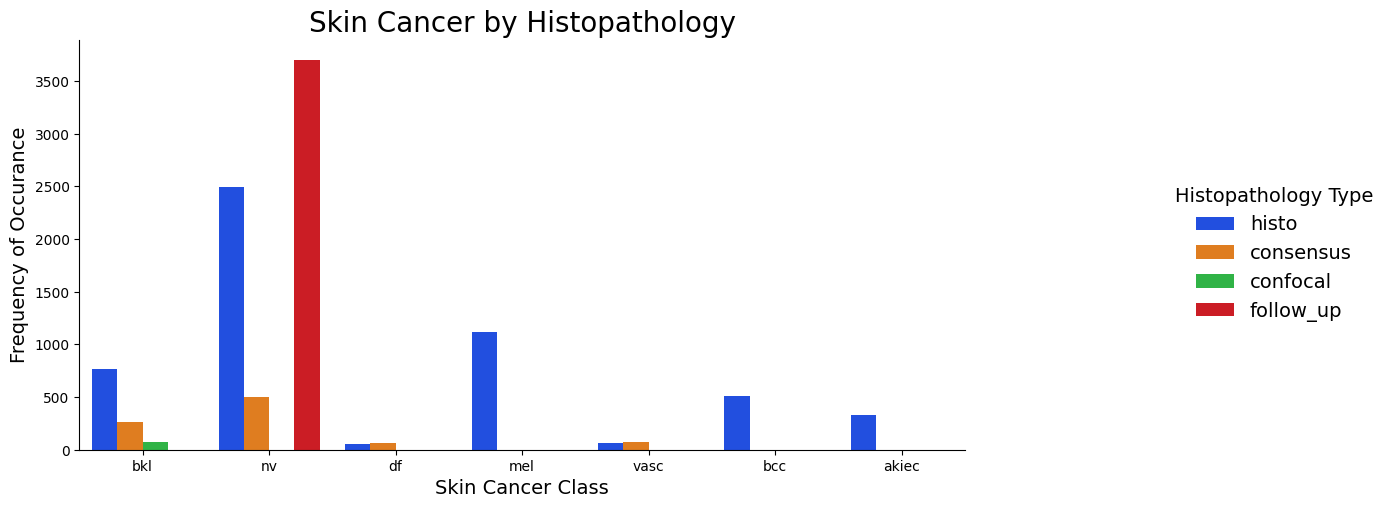

In [35]:
#Skin Cancer is confirmed via Hispathology, let's check the breakdown for each type
g = sns.catplot(x="dx", kind="count", hue="dx_type", palette='bright', data=metadata)
g.fig.set_size_inches(16, 5)

g.ax.set_title('Skin Cancer by Histopathology', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Histopathology Type')

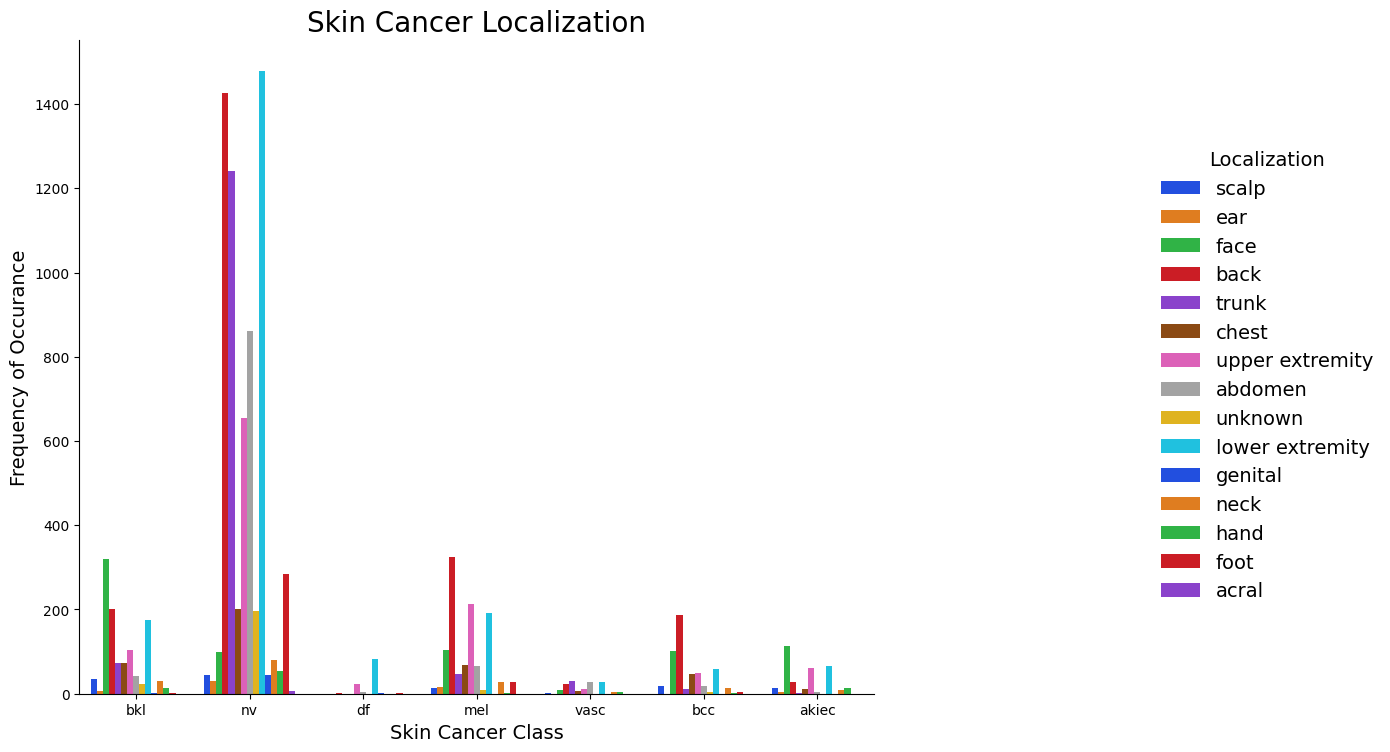

In [36]:
# Skin Cancer occurence body localization
g = sns.catplot(x="dx", kind="count", hue="localization", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer Localization', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Frequency of Occurance', fontsize=14)
g._legend.set_title('Localization')

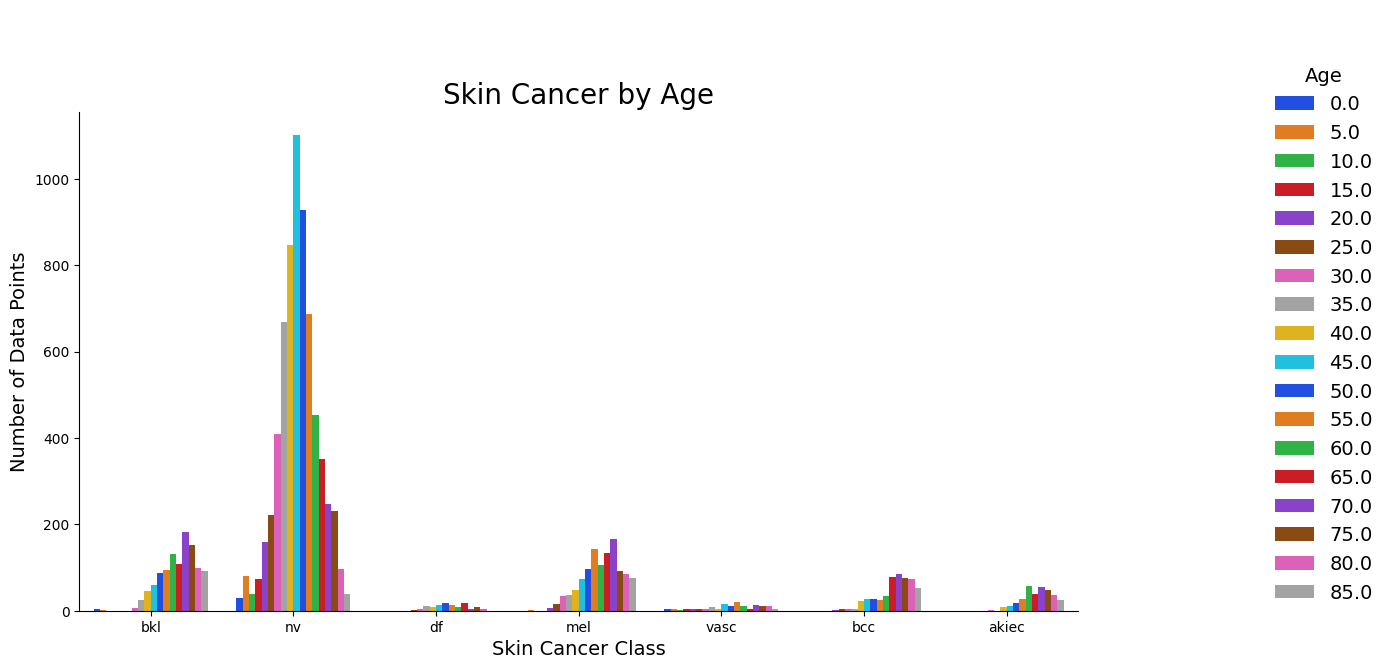

In [37]:
# Skin Cancer occurence by Age
g = sns.catplot(x="dx", kind="count", hue="age", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Age', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Age')

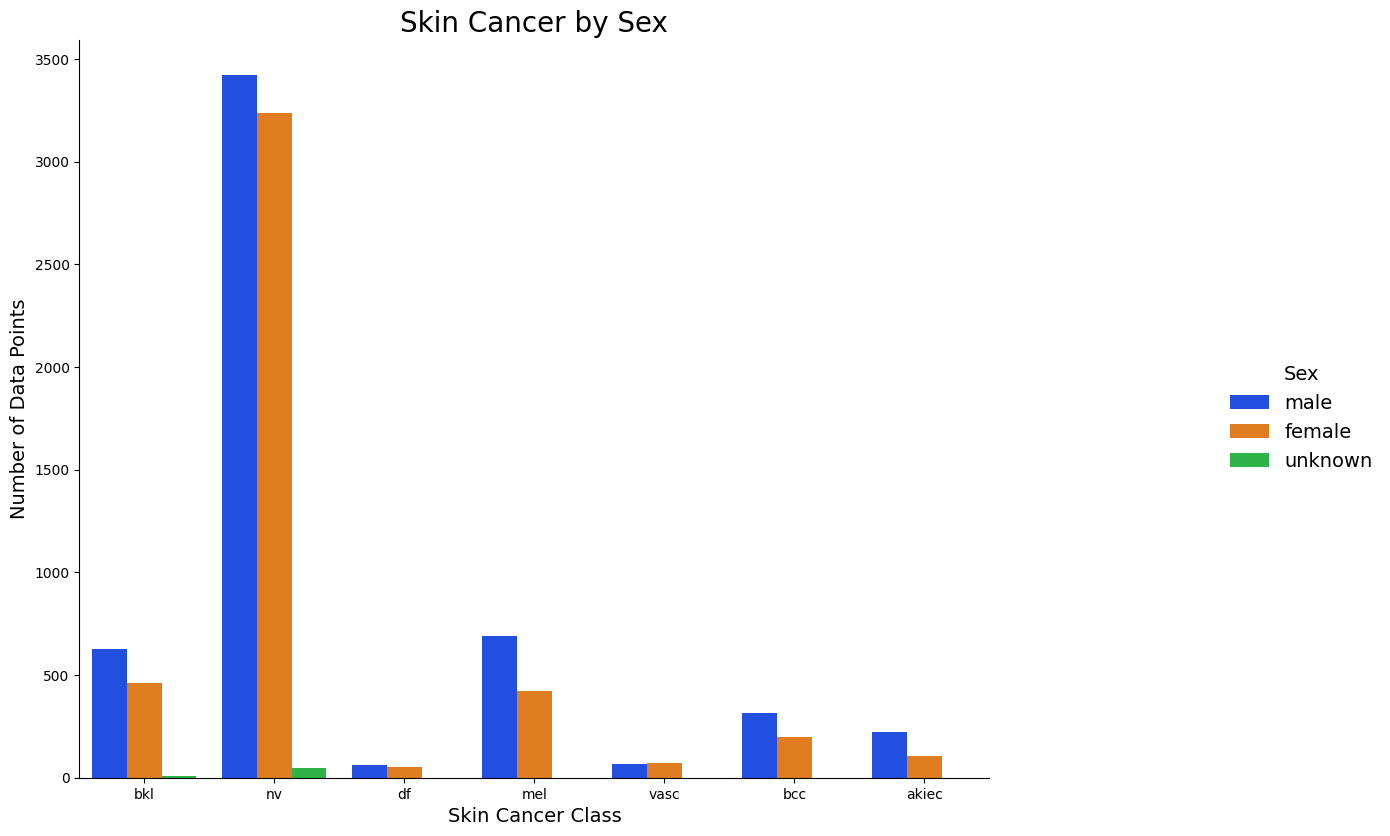

In [38]:
# Skin Cancer occurence by Sex
g = sns.catplot(x="dx", kind="count", hue="sex", palette='bright', data=metadata)
g.fig.set_size_inches(16, 9)

g.ax.set_title('Skin Cancer by Sex', fontsize=20)
g.set_xlabels('Skin Cancer Class', fontsize=14)
g.set_ylabels('Number of Data Points', fontsize=14)
g._legend.set_title('Sex')

# Custom model
Create a custom CNN model and train on the data.  Evaluate using the validation set to estimate the model's accuracy.

In [39]:
# Images are originally 600x450
# I think image_dataset_from_directory scales???
batch_size = 32
#img_height = 180
#img_width = 180
#img_height = 360
#img_width = 360
img_height = 224
img_width = 224
#img_height = 450
#img_width = 600
#img_height = 400
#img_width = 400
rseed = 123

num_epochs=30

In [40]:
data_dir = "./health_small/"
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    #label_mode='int',
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    subset="training",
    seed=rseed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True)

Found 1923 files belonging to 7 classes.
Using 1539 files for training.


In [41]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.20,
    #label_mode='int',
    crop_to_aspect_ratio=True,
    color_mode="rgb",
    subset="validation",
    seed=rseed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle = True)

Found 1923 files belonging to 7 classes.
Using 384 files for validation.


In [42]:
class_names = train_ds.class_names
print(class_names)
num_classes = len(class_names)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


2024-03-18 15:03:36.319286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


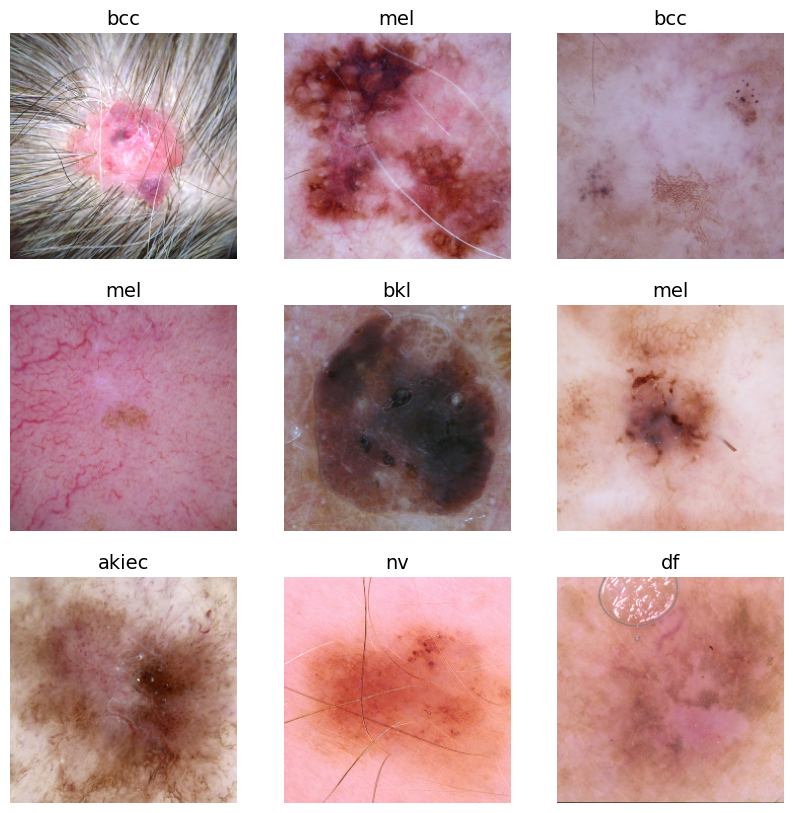

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.savefig("ham_images.png")

# Custom Dataset creation
Based on https://www.tensorflow.org/tutorials/load_data/images

### Get list of file paths for the images

In [44]:
def lookup_path( metadata, file_path ):
    fstr = file_path.numpy().decode("utf-8")
    print(fstr)
    imgid = fstr.split("/")[-1]
    # Get rid of extension so can exactly match the dataframe image_id
    imgid = imgid.replace(".jpg", "")
    row = metadata.loc[ metadata["image_id"] == imgid ]
    #print(f.numpy())
    print( imgid )
    print( row )
    # lesion_id      image_id  dx    dx_type   age   sex     localization
    # the row lookup returns a dataframe or series, but just one value, use iat
    lesion_id = row["lesion_id"].iat[0]
    dx      = row["dx"].iat[0]
    dx_type = row["dx_type"].iat[0]
    age     = row["age"].iat[0]
    sex     = row["sex"].iat[0]
    localization = row["localization"].iat[0]
    return [lesion_id, dx, dx_type, age, sex, localization]

In [45]:
import pathlib
#dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
#archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
#data_dir = pathlib.Path(archive).with_suffix('')
data_dir = pathlib.Path("/mnt/efs/fs1/ham/health_small") # NB: changing type froom str to Path

image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

# NB: Changed to shuffle, hopefully no issues
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

#for f in list_ds:
for f in list_ds.take(5):
    """
    fstr = f.numpy().decode("utf-8")
    print(fstr)
    imgid = fstr.split("/")[-1]
    # Get rid of extension so can exactly match the dataframe image_id
    imgid = imgid.replace(".jpg", "")
    row = metadata.loc[ metadata["image_id"] == imgid ]
    #print(f.numpy())
    print( imgid )
    print( row )
    # lesion_id      image_id  dx    dx_type   age   sex     localization
    # the row lookup returns a dataframe or series, but just one value, use iat
    lesion_id = row["lesion_id"].iat[0]
    dx      = row["dx"].iat[0]
    dx_type = row["dx_type"].iat[0]
    age     = row["age"].iat[0]
    sex     = row["sex"].iat[0]
    localization = row["localization"].iat[0]
    """
    lesion_id, dx, dx_type, age, sex, localization = lookup_path( metadata, f )
    print( f"dx={dx} age={age}  sex={sex}" )


1923
/mnt/efs/fs1/ham/health_small/mel/ISIC_0025674.jpg
ISIC_0025674
        lesion_id      image_id   dx dx_type   age   sex localization
1320  HAM_0000531  ISIC_0025674  mel   histo  85.0  male         face
dx=mel age=85.0  sex=male
/mnt/efs/fs1/ham/health_small/df/ISIC_0029039.jpg
ISIC_0029039
        lesion_id      image_id  dx dx_type   age     sex     localization
1122  HAM_0004317  ISIC_0029039  df   histo  50.0  female  lower extremity
dx=df age=50.0  sex=female
/mnt/efs/fs1/ham/health_small/akiec/ISIC_0030142.jpg
ISIC_0030142
        lesion_id      image_id     dx dx_type   age   sex     localization
9924  HAM_0006434  ISIC_0030142  akiec   histo  60.0  male  lower extremity
dx=akiec age=60.0  sex=male
/mnt/efs/fs1/ham/health_small/akiec/ISIC_0027303.jpg
ISIC_0027303
        lesion_id      image_id     dx dx_type   age   sex     localization
9788  HAM_0000490  ISIC_0027303  akiec   histo  85.0  male  lower extremity
dx=akiec age=85.0  sex=male
/mnt/efs/fs1/ham/health_small/bcc

2024-03-18 15:04:02.698559: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### The tree structure of the files can be used to compile a class_names list.

In [46]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']


### Split the dataset into training and validation sets (still just image file paths)

In [47]:
val_size = int(image_count * 0.2)
train_paths_ds = list_ds.skip(val_size)
val_paths_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_paths_ds).numpy())
print(tf.data.experimental.cardinality(val_paths_ds).numpy())

1539
384


### Short function that converts a file path to an (img, label) pair

In [48]:
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    one_hot = parts[-2] == class_names
    # Integer encode the label
    return tf.argmax(one_hot)

In [49]:
def decode_img(img):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

In [50]:
def process_path(file_path):
    label = get_label(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    #print(img.name)
    # Resize so we can add a batch dimension
    #img = tf.expand_dims(img, axis=0)
    #img = tf.reshape(img, [,img_height, img_width,3])
    #label.file_path = file_path
    # HACKATHON tring to associate key with img or label for post prediction  analysis
    #  This turns out not to work, after calling "ds.batch",  the file_path attribute is lost
    #  Decided easiest to just use the file_paths in val_paths_ds and create  img,label tuples
    #  one at a time, thus we know the file_path (and lookup into metadat), mig, label, and prediction.
    img.file_path = file_path
    label.file_path = file_path
    return img, label

In [51]:
# Testing
img, label = process_path( "./health_small/bcc/ISIC_0026442.jpg" )
print( label.file_path )

./health_small/bcc/ISIC_0026442.jpg


### Use Dataset.map to create a dataset of image, label pairs (instead of file paths)

In [52]:
# Terribly important, when creating custom datasets, we need callback
# funtions to be called in eager mode (i.e. with EagerTensors) 
tf.config.experimental_run_functions_eagerly( run_eagerly=True )

AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_paths_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_paths_ds.map(process_path, num_parallel_calls=AUTOTUNE)

# Terribly important, the shape is [224,244,3] but the models expect an extra batch dimension, e.g. [32, 224, 224, 3]
# This call changes the dataset to iterate over batches instead of instances
train_batched_ds = train_ds.batch(batch_size)
val_batched_ds = val_ds.batch(batch_size)

for image, label in train_batched_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())
print(train_ds)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


/mnt/efs/fs1/venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Image shape:  (32, 224, 224, 3)
Label:  [4 3 3 3 5 4 1 4 0 6 6 0 1 5 4 4 4 3 2 6 2 5 3 1 2 5 4 2 2 1 5 5]
<_ParallelMapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


2024-03-18 15:04:24.085809: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


# Build/train the Models

In [53]:
AUTOTUNE = tf.data.AUTOTUNE

train_batched_ds = train_batched_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_batched_ds = val_batched_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [54]:
# Given three Conv2d layers (32,64,128 maps) and dense (128,64), kernel_sizes 5,5,3 as does 5,3,3
# tf.keras.layers.Conv2D(filters=64, kernel_size=5, strides=(2,2), activation="relu"),
# Given five Conv2d layers, kernel_sizes 5,5,3,3 did ok
# Using strides=(2,2) reduces computational burden as each conv_max pool reduces by four
#   have yet to see a downside, get roughly same accuracy
#   the conv2d+stride is learnable whereas max poolinng is fixed (no params)
model = tf.keras.Sequential([
    # The input_shape=[img_height, img_width, 3] seems to be causing a big problem, not sure about the reascaling
    #tf.keras.layers.Rescaling(1./255, input_shape=[img_height, img_width, 3]), causes an issues for newer tensorflow :(
    tf.keras.layers.Rescaling(1./255, input_shape=(img_height, img_width, 3) ),
    tf.keras.layers.Conv2D(32, 7, strides=2, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(256, 3, padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Oddly, bad idea
    #tf.keras.layers.Dense(32, activation='relu'),
    #tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])

/mnt/efs/fs1/venv/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [55]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
  metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 112, 112, 32)   │         4,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 56, 56, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 56, 56, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,006,727 (7.66 MB)

 Trainable params: 2,006,727 (7.66 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
history = model.fit( train_batched_ds, validation_data=val_batched_ds, epochs=num_epochs )

Epoch 1/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 19s 385ms/step - accuracy: 0.1751 - loss: 1.9456 - val_accuracy: 0.1849 - val_loss: 1.9017
Epoch 2/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 367ms/step - accuracy: 0.1729 - loss: 1.9037 - val_accuracy: 0.1589 - val_loss: 1.8766
Epoch 3/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 364ms/step - accuracy: 0.1689 - loss: 1.8999 - val_accuracy: 0.1589 - val_loss: 1.8904
Epoch 4/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 365ms/step - accuracy: 0.1761 - loss: 1.9008 - val_accuracy: 0.1589 - val_loss: 1.8889
Epoch 5/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 360ms/step - accuracy: 0.1799 - loss: 1.8961 - val_accuracy: 0.1589 - val_loss: 1.8890
Epoch 6/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 353ms/step - accuracy: 0.1618 - loss: 1.8942 - val_accuracy: 0.1589 - val_loss: 1.8896
Epoch 7/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 17s 356ms/step - accuracy: 0.1879 - loss: 1.8852 - val_accuracy: 0.1589 - val_loss: 1.8887
Epoch 8/30
49/49 ━━━━━━━━━━━━━━━━━━━━ 18s 358ms/step - accuracy: 0.1655 - loss: 1.8978 - val_accu

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

In [ ]:
#=====================================================#
# Save model
#=====================================================#
#model.save("skin_cancer_xception_model.keras")

In [365]:
#=====================================================#
# Load model
#=====================================================#
# extra code – show the contents of the my_keras_model/ directory
#for path in sorted(Path("skin_cancer_xception_model").glob("**/*")):
#    print(path)
model = tf.keras.models.load_model("skin_cancer_xception_model.keras")

In [371]:


# Dealing with batches a predictions was too difficult to enumerate, so unbatched
#val_unbatched_ds = val_ds.unbatch()
count = 0
male_count = 0
male_correct = 0
male_incorrect = 0
female_count = 0
female_correct = 0
female_incorrect = 0
#for i, instance in val_ds.enumerate():
#print("===================")
#img, label = instance

y_true = list()
y_pred = list()

for file_path in val_paths_ds:
    #print(file_path.numpy().decode("utf-8"))
    img, label = process_path( file_path )
    # Ground truth
    lesion_id, dx, dx_type, age, sex, localization = lookup_path( metadata, file_path )
    #print(f"i={i}")
    #print(img)
    print(label.file_path)
    pred_probs = model.predict( tf.expand_dims(img, axis=0) )
    #pred_probs = model.predict( img )
    
    #print(pred_probs)
    pred = np.argmax(pred_probs)

    # Keep track to pass to fairness metrics
    # NEED TO CONFIRM: ASSUMING bcc AND mel ARE CANCEROUS
    print( f"pred={pred} dx={dx} label={label}" )
    # pred=1 dx=bkl label=2
    #    0       1     2     3    4     5    6
    # ['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
    y_true.append( int(label) == 4 or int(label) == 1 )
    y_pred.append( pred == 4 or pred == 1 )
    
    if sex == "male":
        #print( pred )
        if pred == label:
            male_correct += 1
        else:
            male_incorrect += 1
        male_count += 1
    else:
        #print( pred )
        if pred == label:
            female_correct += 1
        else:
            female_incorrect += 1
        female_count += 1
    
    #if count % 10 == 0:
    #  print(f"  accuracy={correct/count:.2f}")
    count += 1
    if count > 10:
        break


#print(f"count={count}")
#print(f"correct={correct}")
#print(f"incorrect={incorrect}")
#print(f"accuracy={correct/count:.2f}")
print(f"accuracy={male_correct/male_count:.2f} MALE")
print(f"accuracy={female_correct/female_count:.2f} FEMALE")

print(y_true)
print(y_pred)

# /opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258:
# UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this
# option does not apply to tf.data functions. To force eager execution of tf.data functions,
# please use `tf.data.experimental.enable_debug_mode()`.

/opt/dlami/nvme/health_small/bkl/ISIC_0029249.jpg
ISIC_0029249
       lesion_id      image_id   dx dx_type   age     sex localization
504  HAM_0005869  ISIC_0029249  bkl   histo  75.0  female        chest
tf.Tensor(b'/opt/dlami/nvme/health_small/bkl/ISIC_0029249.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
pred=2 dx=bkl label=2
/opt/dlami/nvme/health_small/nv/ISIC_0027761.jpg
ISIC_0027761
        lesion_id      image_id  dx    dx_type   age   sex localization
5320  HAM_0000663  ISIC_0027761  nv  follow_up  50.0  male        trunk
tf.Tensor(b'/opt/dlami/nvme/health_small/nv/ISIC_0027761.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred=5 dx=nv label=5
/opt/dlami/nvme/health_small/nv/ISIC_0031338.jpg
ISIC_0031338
        lesion_id      image_id  dx    dx_type   age     sex localization
6253  HAM_0005996  ISIC_0031338  nv  follow_up  55.0  female         back
tf.Tensor(b'/opt/dlami/nvme/health_small/nv/ISIC_0031338.jpg', shape=(), dtype=string

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
pred=5 dx=nv label=5
/opt/dlami/nvme/health_small/vasc/ISIC_0026876.jpg
ISIC_0026876
        lesion_id      image_id    dx    dx_type  age     sex localization
2388  HAM_0002610  ISIC_0026876  vasc  consensus  0.0  female      abdomen
tf.Tensor(b'/opt/dlami/nvme/health_small/vasc/ISIC_0026876.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
pred=4 dx=vasc label=6
/opt/dlami/nvme/health_small/akiec/ISIC_0028232.jpg
ISIC_0028232
        lesion_id      image_id     dx dx_type   age   sex localization
9736  HAM_0003123  ISIC_0028232  akiec   histo  60.0  male         face
tf.Tensor(b'/opt/dlami/nvme/health_small/akiec/ISIC_0028232.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
pred=0 dx=akiec label=0
/opt/dlami/nvme/health_small/nv/ISIC_0032293.jpg
ISIC_0032293
        lesion_id      image_id  dx    dx_type   age     sex     localization
5726  HAM_0000123  ISIC_0032293  nv  follow_up  50.0  female  upper extremit

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred=4 dx=mel label=4
/opt/dlami/nvme/health_small/mel/ISIC_0024739.jpg
ISIC_0024739
        lesion_id      image_id   dx dx_type   age   sex     localization
2307  HAM_0001910  ISIC_0024739  mel   histo  55.0  male  upper extremity
tf.Tensor(b'/opt/dlami/nvme/health_small/mel/ISIC_0024739.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred=4 dx=mel label=4
/opt/dlami/nvme/health_small/mel/ISIC_0033814.jpg
ISIC_0033814
        lesion_id      image_id   dx dx_type   age   sex localization
1544  HAM_0002086  ISIC_0033814  mel   histo  70.0  male         face
tf.Tensor(b'/opt/dlami/nvme/health_small/mel/ISIC_0033814.jpg', shape=(), dtype=string)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
pred=4 dx=mel label=4
/opt/dlami/nvme/health_small/df/ISIC_0032468.jpg
ISIC_0032468
        lesion_id      image_id  dx dx_type   age     sex     localization
1102  HAM_0005684  ISIC_0032468  df   histo  75.0  female  lower extremity
tf.Tensor(b'/opt/d

/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use

In [485]:
metadata_sample_df = metadata.sample(100, random_state=123456)
print(class_names)
print(class_names.shape)
metadata_sample_df.head(n=10)

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
(7,)


,lesion_id,image_id,dx,dx_type,age,sex,localization
3015,HAM_0002202,ISIC_0027315,nv,follow_up,50.0,male,trunk
1982,HAM_0003400,ISIC_0032197,mel,histo,50.0,male,face
5904,HAM_0000387,ISIC_0031826,nv,follow_up,25.0,female,trunk
1753,HAM_0007558,ISIC_0033120,mel,histo,45.0,male,upper extremity
1866,HAM_0007592,ISIC_0027149,mel,histo,80.0,male,upper extremity
173,HAM_0005258,ISIC_0033262,bkl,histo,60.0,female,lower extremity
9654,HAM_0001393,ISIC_0029030,nv,consensus,55.0,female,back
5524,HAM_0003085,ISIC_0027809,nv,follow_up,45.0,female,trunk
960,HAM_0002792,ISIC_0033169,bkl,consensus,80.0,female,back
6574,HAM_0000731,ISIC_0026813,nv,follow_up,40.0,female,upper extremity


In [486]:
y_true = list()
y_pred = list()

# NB: Using all of health dataset, model may have been trained on subset
for index, row in metadata_sample_df.iterrows():
    # health_small/nv/ISIC_0027761.jpg
    dx = row['dx']
    image_id = row['image_id']
    file_path = f"./health/{dx}/{image_id}.jpg"
    #print( f"dx={dx}  image_id={image_id} file_path={file_path}" )

    #========================#
    img, label = process_path( file_path )
    pred_probs = model.predict( tf.expand_dims(img, axis=0) )
    pred = np.argmax(pred_probs)
    #========================#

    y_true.append( int(label) )
    y_pred.append( pred )
print(y_true)
print(y_pred)

dx=nv  image_id=ISIC_0027315 file_path=./health/nv/ISIC_0027315.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
dx=mel  image_id=ISIC_0032197 file_path=./health/mel/ISIC_0032197.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=nv  image_id=ISIC_0031826 file_path=./health/nv/ISIC_0031826.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=mel  image_id=ISIC_0033120 file_path=./health/mel/ISIC_0033120.jpg


/opt/conda/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=mel  image_id=ISIC_0027149 file_path=./health/mel/ISIC_0027149.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=bkl  image_id=ISIC_0033262 file_path=./health/bkl/ISIC_0033262.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=nv  image_id=ISIC_0029030 file_path=./health/nv/ISIC_0029030.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=nv  image_id=ISIC_0027809 file_path=./health/nv/ISIC_0027809.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=bkl  image_id=ISIC_0033169 file_path=./health/bkl/ISIC_0033169.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=nv  image_id=ISIC_0026813 file_path=./health/nv/ISIC_0026813.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=akiec  image_id=ISIC_0028659 file_path=./health/akiec/ISIC_0028659.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=mel  image_id=ISIC_0034022 file_path=./health/mel/ISIC_0034022.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
dx=mel  image_id=ISIC_0032797 file_path=./health/mel/ISIC_0032797.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23

In [487]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(class_names)
metadata_sample_df["dx"] = le.transform(metadata_sample_df["dx"])
sex_labels = np.array( ['male','female'] ) # NOT SURE WHY THIS IS NOT WORKING, female should be 1
le.fit(sex_labels)
metadata_sample_df["sex"] = le.transform( metadata_sample_df["sex"] )
#metadata_sample_df = pd.get_dummies(metadata_sample_df, columns=['sex', 'localization'])

#metadata_sample_df = pd.get_dummies(metadata_sample_df, columns=['dx'])
metadata_sample_df.drop(["image_id", "lesion_id", "dx_type", "localization"], axis=1, inplace=True)
metadata_sample_df.head(n=10)

,dx,age,sex
3015,5,50.0,1
1982,4,50.0,1
5904,5,25.0,0
1753,4,45.0,1
1866,4,80.0,1
173,2,60.0,0
9654,5,55.0,0
5524,5,45.0,0
960,2,80.0,0
6574,5,40.0,0


In [488]:
# https://stackoverflow.com/questions/64506977/calculate-group-fairness-metrics-with-aif360
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

dataset = StandardDataset(metadata_sample_df, 
                          label_name='dx', 
                          favorable_classes=[1,4], 
                          protected_attribute_names=['sex'], 
                          privileged_classes=[[1]])

def fair_metrics(dataset, y_pred):
    dataset_pred = dataset.copy()
    dataset_pred.labels = y_pred
        
    attr = dataset_pred.protected_attribute_names[0]
    
    idx = dataset_pred.protected_attribute_names.index(attr)
    privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
    unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 

    classified_metric = ClassificationMetric(dataset, dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    metric_pred = BinaryLabelDatasetMetric(dataset_pred, unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)

    result = {'statistical_parity_difference': metric_pred.statistical_parity_difference(),
             'disparate_impact': metric_pred.disparate_impact(),
             'equal_opportunity_difference': classified_metric.equal_opportunity_difference()}
        
    return result


fair_metrics(dataset, np.array(y_pred) )

{'statistical_parity_difference': -0.01223990208078335,
 'disparate_impact': 0.8837209302325582,
 'equal_opportunity_difference': 0.35}

# Residual CNN
Create a well known resnet model and train/evaluate.

In [ ]:
from functools import partial

DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="same", kernel_initializer="he_normal",
                        use_bias=False)

class ResidualLayer(tf.keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = tf.keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            tf.keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            tf.keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                tf.keras.layers.BatchNormalization()
            ]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [ ]:
model = tf.keras.Sequential([
    DefaultConv2D(64, kernel_size=7, strides=2, input_shape=[img_height, img_width, 3]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same"),
])
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualLayer(filters, strides=strides))
    prev_filters = filters

model.add(tf.keras.layers.GlobalAvgPool2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(num_classes, activation="softmax"))

In [ ]:
# compiles and provide model summary
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

In [ ]:
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

# Transfer Learning
We use existing model architecture and its pre-trained weights.  The base model was trained on the ImageNet dataset that has 1000 classes (the top layer uses a softmax to classify from the one thousand categories).  We only have 7 classes so will only need the model/weights for the representation learning part of the base model and exclude the top layer.  We will than add our top layer for the seven classes.  Then we will then unfreeze all the layers of the base model (i.e. make trainable). Finally, we train new model on our data.

In [ ]:
#num_classes=7
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.resnet_v2.ResNet50V2(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(weights="imagenet", include_top=False)
#base_model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(num_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [ ]:
# After changing trainnable need to compile
for layer in base_model.layers:
    layer.trainable = True

# compiles and provide model summary ""
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.summary()

In [ ]:
# fits, evaluates, and uses the model to make predictions
num_epochs=20
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

In [ ]:
pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
#save_fig("keras_learning_curves_plot")  # extra code
plt.show()

# Save the model

## Save the model to use later for predicting the type of mole/skin images.

In [ ]:
#=====================================================#
# Save model
#=====================================================#
model.save("skin_cancer_xception_model.keras")

In [ ]:
!cp -r ./skin_cancer_xception_model /content/drive/MyDrive/.

## Reading and using saved model
This is an example of reading back in just the model and using.  You will still need to import libraries, etc.

In [ ]:
!cp -r /content/drive/MyDrive/skin_cancer_xception_model .

In [ ]:
#=====================================================#
# Sometime later, restore model
#=====================================================#
# extra code – show the contents of the my_keras_model/ directory
#for path in sorted(Path("skin_cancer_xception_model").glob("**/*")):
#    print(path)
model = tf.keras.models.load_model("skin_cancer_xception_model.keras")
#evaluate_model(model)
# fits, evaluates, and uses the model to make predictions
num_epochs=10
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

In [ ]:
def show_history(history, num_epochs):
    pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, num_epochs], ylim=[0, 1], grid=True, xlabel="Epoch",
        style=["r--", "r--.", "b-", "b-*"])
    plt.legend(loc="lower left")  # extra code
    #save_fig("keras_learning_curves_plot")  # extra code
    plt.show()

In [ ]:
show_history(history, num_epochs)

# ISIS/DICOM Testing

In [41]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 48.9 MB/s eta 0:00:0000:01


In [43]:
import pydicom
from pydicom.data import get_testdata_file

In [97]:
#dcm_filename = "./ISIS/test/ISIC_7977981.dcm"  
dcm_filename = "./ISIS/train/ISIC_9999806.dcm"
dcm_path = os.path.join(".",dcm_filename)
dcm_img = pydicom.dcmread( dcm_path, force = True )
print(dcm_img)

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 218
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: VL Photographic Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.5962.99.1.1145.9492.1620348114777.1.1.1.1.1
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.5962.99.2
(0002, 0013) Implementation Version Name         SH: 'PIXELMEDJAVA001'
(0002, 0016) Source Application Entity Title     AE: 'OURAETITLE'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['DERIVED', 'SECONDARY']
(0008, 0014) Instance Creator UID                UI: 1.3.6.1.4.1.5962.99.3
(0008, 0016) SOP Class UID                       UI: VL Photographic Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.

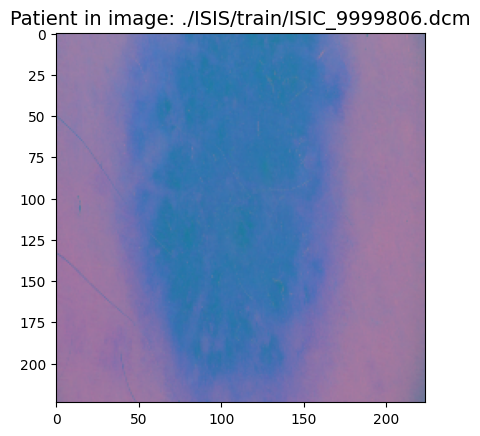

In [165]:
img_array = dcm_img.pixel_array
#print(img_array.shape)
# img_array seems to be regular array (or perhaps numpy), compatible with tensorflow resize
img_array_resized = tf.image.resize(img_array, [img_height, img_width])
# img_array_resized is now a tensor and can be converted into numpy to display
#print(img_array_resized.shape)

plt.imshow(img_array_resized.numpy().astype("uint8"))

#if label == 0:
#    category = "doesn't have cancer"
#elif label == 1:
#    category = "has cancer"

plt.title(f'Patient in image: {dcm_filename}');

In [95]:
isic_metadata=pd.read_csv(os.path.join("./ISIS/",'ISIC_2020_Training_GroundTruth.csv'))
isic_metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33126 entries, 0 to 33125
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   image_name                     33126 non-null  object 
 1   patient_id                     33126 non-null  object 
 2   sex                            33061 non-null  object 
 3   age_approx                     33058 non-null  float64
 4   anatom_site_general_challenge  32599 non-null  object 
 5   diagnosis                      33126 non-null  object 
 6   benign_malignant               33126 non-null  object 
 7   target                         33126 non-null  int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 2.0+ MB


In [96]:
isic_metadata.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [259]:
def lookup_dcm_path( metadata, file_path ):
    # NB: file_path should be str object with path to the dcm file
    #file_path = f.numpy().decode("utf-8")
    #file_path = str(f)
    imgid = file_path.split("/")[-1]
    # Get rid of extension so can exactly match the dataframe image_id
    img_name = imgid.replace(".dcm", "")
    row = metadata.loc[ metadata["image_name"] == img_name ]
    # Should be only one row, i.e. img_name exists and is unique in the dataframe
    #print( f"FOUND {row.shape}" )
    #print( img_name )
    #print( row )
    #num_rows = row.shape[0]
    #if( num_rows > 0 ):
    # lesion_id      image_id  dx    dx_type   age   sex     localization
    # the row lookup returns a dataframe or series, but just one value, use iat
    patient_id = row["patient_id"].iat[0]
    diagnosis  = row["diagnosis"].iat[0]
    benign  = row["benign_malignant"].iat[0]
    age     = row["age_approx"].iat[0]
    sex     = row["sex"].iat[0]
    localization = row["anatom_site_general_challenge"].iat[0]
    return [patient_id, img_name, diagnosis, benign, age, sex, localization]
      

In [260]:
example_metadata = lookup_dcm_path( isic_metadata, "./ISIS/train/ISIC_9999806.dcm" )
print(example_metadata)

['IP_0046310', 'ISIC_9999806', 'nevus', 'benign', 45.0, 'male', 'torso']


In [261]:
# NB: Changed to shuffle, hopefully no issues
data_dir = pathlib.Path("ISIS/train")
print(f"data_dir={data_dir}")
image_count = len(list(data_dir.glob('*.dcm')))
print(f"Found {image_count} dcm files in directory {data_dir}")
# ISSUE: There are 44108 in ISIS, this includes both train and test
#        but only train images have metadata
# Total 44108: training 33126, test 10982

data_dir=ISIS/train
Found 33126 dcm files in directory ISIS/train


In [301]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*'), shuffle=True)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

print( "list_ds" )
print( type(list_ds) )

# This was attempt to make mapping much simpler with a dict instead of reading the dataframe
#file2benign = dict()
#for f in list_ds:
for f in list_ds.take(5):
    # f is <class 'tensorflow.python.framework.ops.EagerTensor'>
    #print( type(f) ) 
    #file_path = f.numpy().decode("utf-8")
    file_path = tf.get_static_value(f).decode("utf-8")
    # tf.get_static_value(f) returns bytes and can safely now convert into str
    print( file_path )
    results = lookup_dcm_path( isic_metadata, file_path )
    patient_id, img_name, diagnosis, benign, age, sex, localization = results
    #file2benign[file_path] = benign
    #print( f"POPE img_name={file_path} age={age}  sex={sex} benign={benign}" )
#print( f"Mapped {len(file2benign)}" )

list_ds
<class 'tensorflow.python.data.ops.shuffle_op._ShuffleDataset'>
ISIS/train/ISIC_9748173.dcm
ISIS/train/ISIC_1486076.dcm
ISIS/train/ISIC_3100178.dcm
ISIS/train/ISIC_9525579.dcm
ISIS/train/ISIC_2307167.dcm


2024-03-17 22:19:46.934233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [294]:
# NB: implicit parameter "isic_metadata"
def get_label_dcm(file_path):
    # Convert the path to a list of path components
    patient_id, img_name, diagnosis, benign, age, sex, localization = lookup_dcm_path( isic_metadata, file_path )
    #benign  = file2benign[file_path]
    #print(f"  {file_path} {benign}")
    # Integer encode the label
    if( benign == "benign" ):
        return 0  # benign
    return 1 # malignant  (i.e. cancer)

In [295]:
# NB: implicit parameters "img_height" and "img_width"
def decode_img_dcm(img):
    # Convert the compressed string to a 3D uint8 tensor
    dcm_img = pydicom.dcmread( dcm_path, force = True )
    img_array = dcm_img.pixel_array
    # Resize the image to the desired size
    img_array_resized = tf.image.resize(img_array, [img_height, img_width])
    return img_array_resized

In [316]:
def process_path_dcm(f):
    # Convert f (some type of Tensor) to a str
    # Easiest for get_label_dcm and decode_img_dcm to use str
    #print(tf.executing_eagerly())
    # DOES NOT WORK WHEN  NOT IN "eager mode"
    # print(tf.executing_eagerly()) see https://www.tensorflow.org/api_docs/python/tf/executing_eagerly
    # Expect:  <class 'tensorflow.python.framework.ops.EagerTensor'>
    # But get: <class 'tensorflow.python.framework.ops.SymbolicTensor'>
    # When the map function is used.  What a pain in the ass.
    # https://stackoverflow.com/questions/52357542/attributeerror-tensor-object-has-no-attribute-numpy
    file_path = f.numpy().decode("utf-8")
    
    #file_path = tf.get_static_value(f).decode("utf-8")
    #print( f"  {file_path}" )
    label = get_label_dcm(file_path)
    # Load the raw data from the file as a string
    img = decode_img_dcm(file_path)
    return img, label

In [317]:
# DEBUGGING
for f in list_ds.take(20):
    #file_path = f.numpy().decode("utf-8")
    img, label = process_path_dcm(f)
    print(f"Transformed {file_path} cancer ? {label}")

Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_2307167.dcm cancer ? 0
Transformed ISIS/train/ISIC_230

2024-03-17 22:55:00.444609: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


### Use Dataset.map to create a dataset of image, label pairs (instead of file paths)

### Split the dataset into training and validation sets (still just image file paths)

In [318]:
val_size = int(image_count * 0.2)
train_paths_ds = list_ds.skip(val_size)
val_paths_ds = list_ds.take(val_size)
print(tf.data.experimental.cardinality(train_paths_ds).numpy())
print(tf.data.experimental.cardinality(val_paths_ds).numpy())

26501
6625


In [319]:
tf.config.run_functions_eagerly(True)

AUTOTUNE = tf.data.AUTOTUNE

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_paths_ds.map(process_path_dcm, num_parallel_calls=AUTOTUNE )
val_ds = val_paths_ds.map(process_path_dcm, num_parallel_calls=AUTOTUNE )

# The lambda in the map is because Tensorflow really sucks, causes the mapping functions to be called with EagerTensors
#train_ds = train_paths_ds.map(lambda tpl: tf.py_function(process_path_dcm, [tpl], [tf.string]), num_parallel_calls=AUTOTUNE )
#val_ds = val_paths_ds.map(lambda tpl: tf.py_function(process_path_dcm, [tpl], [tf.string]), num_parallel_calls=AUTOTUNE )

# Terribly important, the shape is [224,244,3] but the models expect an extra batch dimension, e.g. [32, 224, 224, 3]
# This call changes the dataset to iterate over batches instead of instances
train_batched_ds = train_ds.batch(batch_size)
val_batched_ds = val_ds.batch(batch_size)

for image, label in train_batched_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
print(train_ds)

AttributeError: in user code:

    File "/tmp/ipykernel_2188/174394435.py", line 4, in process_path_dcm  *
        file_path = f.numpy().decode("utf-8")

    AttributeError: 'SymbolicTensor' object has no attribute 'numpy'
